In [1]:
import numpy as np
import scipy as p
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
from scipy import odr
from scipy.stats import t
from scipy.stats import chi2

In [2]:
def STLSQ(Theta: np.ndarray,dXdt: np.ndarray, lambd: float, n_iter: int = 10) -> np.ndarray:
                                                        
    # Initial ordinary least-squares fit
    Xi, *_ = np.linalg.lstsq(Theta, dXdt, rcond=None)

    for _ in range(n_iter):
        # Hard-threshold small coefficients
        smallinds = np.abs(Xi) < lambd
        Xi[smallinds] = 0.0

        # For each state variable, refit using the remaining “large” basis functions
        for ind in range(Xi.shape[1]):      # n = Xi.shape[1]
            biginds = ~smallinds[:, ind]    # True means this basis function is kept
            if not np.any(biginds):
                continue                    # Skip if the entire column was zeroed
            Xi[biginds, ind], *_ = np.linalg.lstsq(
                Theta[:, biginds],          # Reduced library matrix
                dXdt[:, ind],               # Target derivative for this state
                rcond=None
            )

    return Xi


## Case1: function

In [7]:
# L2([-1,1]) normalization factor: factor[k] = sqrt((2k+1)/2)
def l2_norm_factors(deg: int) -> np.ndarray:
    return np.sqrt((2 * np.arange(deg + 1) + 1) / 2)

def _odr_fit_powers(x: np.ndarray,
                    y: np.ndarray,
                    powers: np.ndarray,
                    factors: np.ndarray,
                    beta0: np.ndarray | None = None,
                    sx: float | np.ndarray = 0.06,
                    sy: float | np.ndarray = 0.1) -> np.ndarray:
    powers = np.asarray(powers)

    def poly_model(beta, x):
        out = np.zeros_like(x, dtype=float)
        for j, p in enumerate(powers):
            out += beta[j] * (x**p) * factors[p]  # normalized basis
        return out

    model = odr.Model(poly_model)
    data  = odr.RealData(x, y, sx=sx, sy=sy)

    if beta0 is None:
        # Use the normalized Θ submatrix to perform LSQ as the initial guess
        Theta_norm = np.vstack([(x**p) * factors[p] for p in powers]).T
        beta0 = np.linalg.lstsq(Theta_norm, y, rcond=None)[0].ravel()

    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta  # coefficients under the normalized basis (corresponding to powers)

# STLSQ + ODR (internally uses normalized coefficients, finally denormalizes)
def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:
    """
    Returns: beta (deg+1, n_states) — denormalized, can be directly multiplied with x^k
    """
    factors = l2_norm_factors(deg)
    n_features, n_states = deg + 1, dXdt.shape[1]

    # Xi_norm: coefficients under the normalized basis
    Xi_norm = np.zeros((n_features, n_states))
    all_powers = np.arange(deg + 1)

    # Initial fitting (all powers)
    for k in range(n_states):
        Xi_norm[:, k] = _odr_fit_powers(x, dXdt[:, k], all_powers, factors, sx=sx, sy=sy)

    # Iterative sparsification (thresholding on the normalized scale)
    for _ in range(n_iter):
        small = np.abs(Xi_norm) < lambd
        Xi_norm[small] = 0.0

        for k in range(n_states):
            powers_kept = np.flatnonzero(~small[:, k])
            if powers_kept.size == 0:
                continue
            # Refit on the retained powers
            beta_sub = _odr_fit_powers(x, dXdt[:, k], powers_kept, factors, sx=sx, sy=sy)
            # Write back to the corresponding positions (still under normalized basis)
            Xi_norm[powers_kept, k] = beta_sub
            # Deleted terms remain as 0

    # Denormalize to standard polynomial coefficients: beta = Xi_norm * factor
    beta = Xi_norm * factors[:, None]
    return beta


In [3]:

def _odr_fit(A: np.ndarray, b: np.ndarray, beta0: np.ndarray | None = None) -> np.ndarray:
 
    # polynomial model
    def poly_model(beta, x):
        return np.dot(beta, x)

    model = odr.Model(poly_model)
    data  = odr.RealData(A.T, b, sx= 0.1, sy = 0.1)           

    if beta0 is None:                       # LSQ as the initial value
        beta0 = np.linalg.lstsq(A, b, rcond=None)[0]
    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta


def STLSQ_ODR(Theta: np.ndarray,
              dXdt: np.ndarray,
              lambd: float,
              n_iter: int = 10) -> np.ndarray:

    n_features, n_states = Theta.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    # ODR fit
    for k in range(n_states):
        Xi[:, k] = _odr_fit(Theta, dXdt[:, k])

    # Iteration: thresholding + refitting
    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        # Large coefficients retained by re-ODR fitting for each state
        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue
            Xi[keep, k] = _odr_fit(Theta[:, keep], dXdt[:, k])

    return Xi

=== Method 1 (BIC) ===
Chosen λ     : 0.008227241341700473
Sparse coeffs: [ 2.9988 -1.9993  0.      0.4953  0.      1.0023]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.014302139579016914
Sparse coeffs: [ 2.9987 -1.9992  0.      0.4954  0.      1.0017]


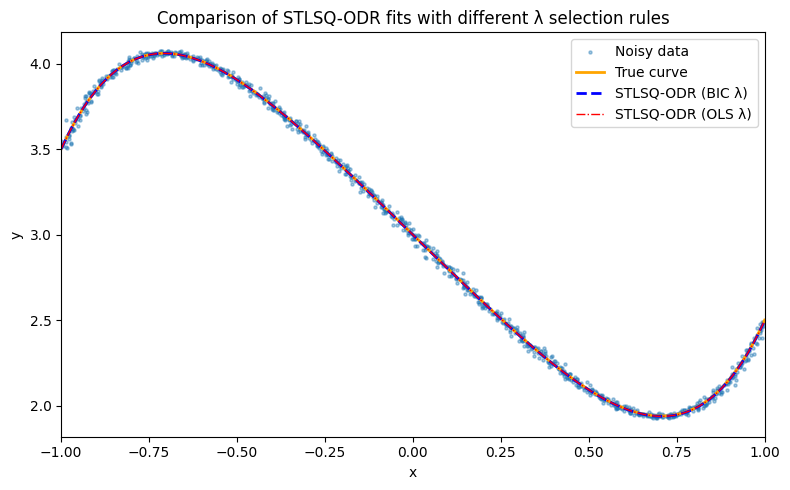

In [18]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise to both x and y
x_noisy = x_true + 0.01 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.01 * np.random.randn(m)
y = y_noisy[:, None]  


# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()


=== Method 1 (BIC) ===
Chosen λ     : 0.03352924149249558
Sparse coeffs: [ 2.9939 -2.0002  0.      0.5038  0.      0.964 ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.027153982438217008
Sparse coeffs: [ 2.9849 -2.0044  0.0654  0.5409 -0.0736  0.9216]


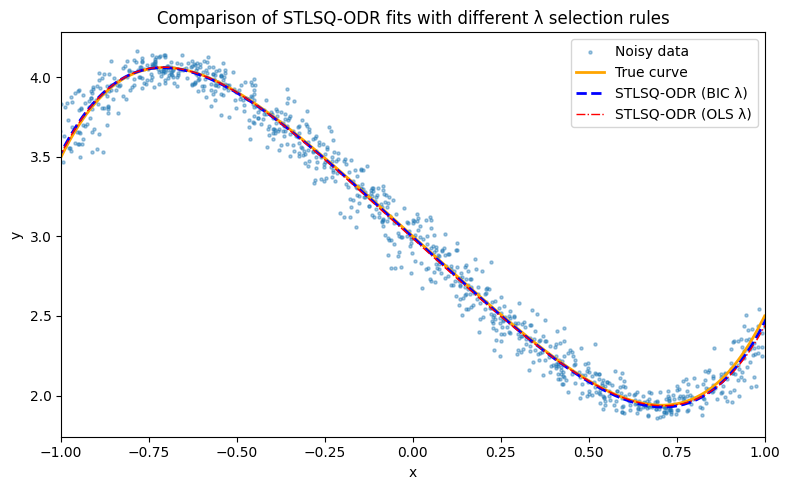

In [24]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise to both x and y
x_noisy = x_true + 0.05 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.05 * np.random.randn(m)
y = y_noisy[:, None]  


# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.06768750009458535
Sparse coeffs: [ 2.9886 -2.0003  0.      0.5276  0.      0.8613]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.019529395094603875
Sparse coeffs: [ 2.9707 -2.0291  0.1212  0.7154 -0.1263  0.6722]


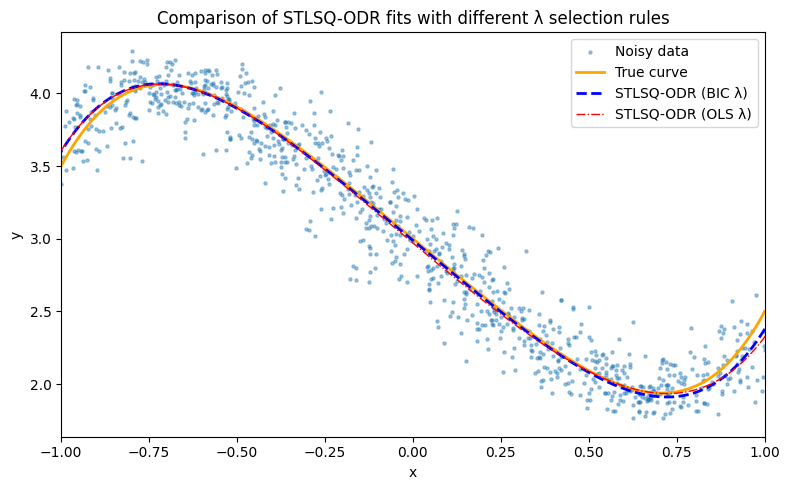

In [4]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise to both x and y
x_noisy = x_true + 0.1 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)
y = y_noisy[:, None]  


# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()


=== Method 1 (BIC) ===
Chosen λ     : 0.06020894493336132
Sparse coeffs: [ 2.9842 -2.4241  0.      2.2096  0.     -0.605 ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.012057940949605883
Sparse coeffs: [ 2.9517 -2.3243  0.1344  2.0646 -0.0765 -0.5754]


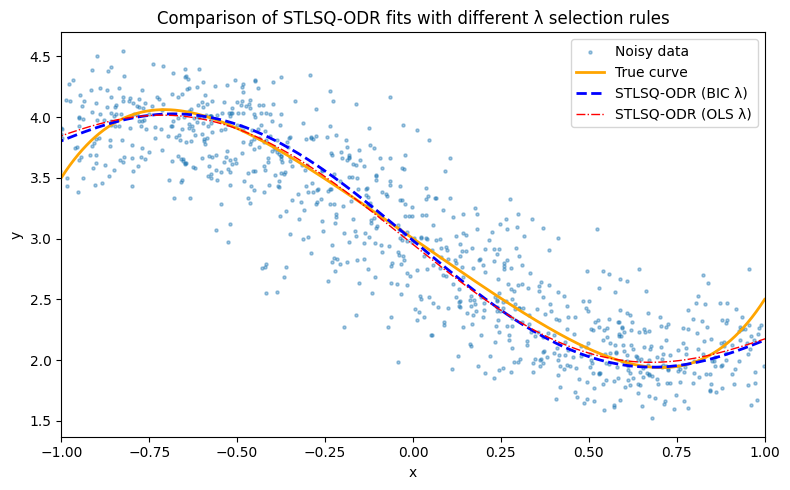

In [ ]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise to both x and y
x_noisy = x_true + 0.2 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.2 * np.random.randn(m)
y = y_noisy[:, None]  


# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()


=== Method 1 (BIC) ===
Chosen λ     : 0.03352924149249558
Sparse coeffs: [ 2.9827 -2.5165  0.      2.1296  0.     -0.4999]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.005280964529394173
Sparse coeffs: [ 2.9579 -2.5881  0.0552  2.58    0.     -0.7739]


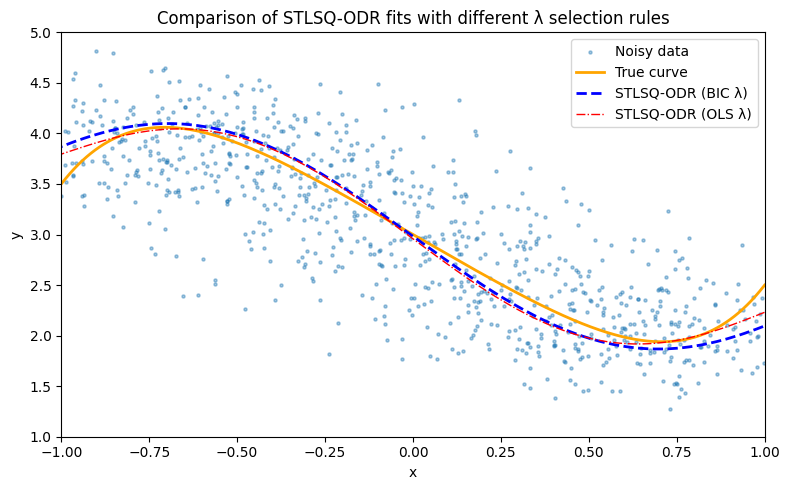

In [30]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise to both x and y
x_noisy = x_true + 0.3 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.3 * np.random.randn(m)
y = y_noisy[:, None]  


# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.ylim(1, 5)
plt.tight_layout()
plt.show()


=== Method 1 (BIC) ===
Chosen λ     : 0.4953535208959175
Sparse coeffs: [ 2.9852 -1.1211  0.      0.      0.      0.    ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.02420094141199163
Sparse coeffs: [ 2.9867 -2.9961  0.      2.8952  0.     -0.7148]


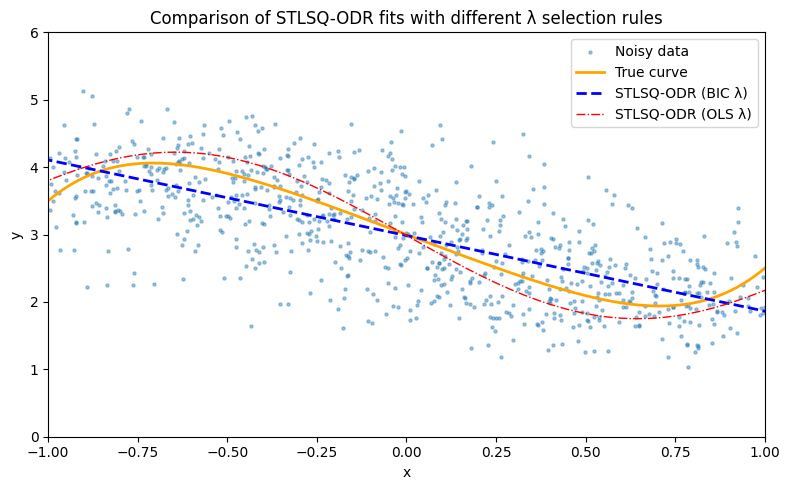

In [5]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise to both x and y
x_noisy = x_true + 0.4 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.4 * np.random.randn(m)
y = y_noisy[:, None]  


# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.ylim(0, 6)
plt.tight_layout()
plt.show()


# Case 2

=== Method 1 (BIC) ===
Chosen λ     : 0.002868316813342012
Sparse coeffs: [ 3.0014 -2.0038  0.      0.5251  0.      0.9711]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.004660359794024726
Sparse coeffs: [ 3.0015 -2.0045  0.      0.5308  0.      0.9647]


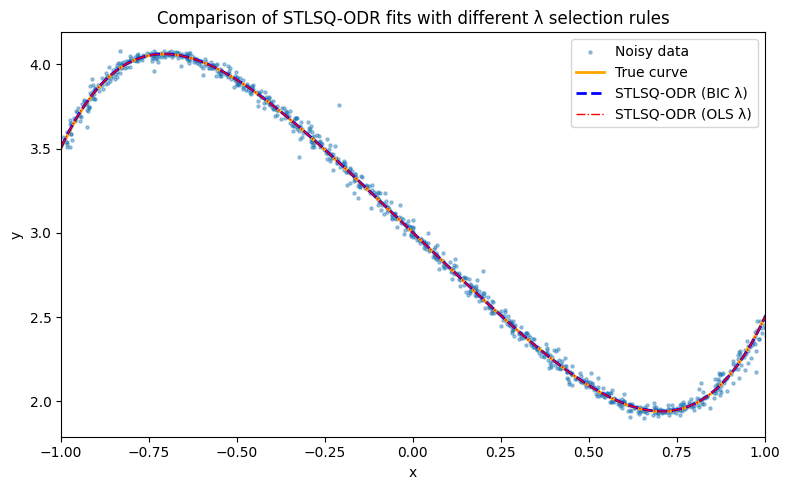

In [33]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add Student-t noise to both x and y
df = 3   # degrees of freedom (small df → heavier tails)
x_noisy = x_true + 0.01 * t.rvs(df, size=m, random_state=0)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.01 * t.rvs(df, size=m, random_state=1)
y = y_noisy[:, None]

# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.34863652276780877
Sparse coeffs: [ 3.006  -2.234   0.      1.5504  0.      0.    ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.027963320073054798
Sparse coeffs: [ 3.0066 -2.0499  0.      0.8198  0.      0.6164]


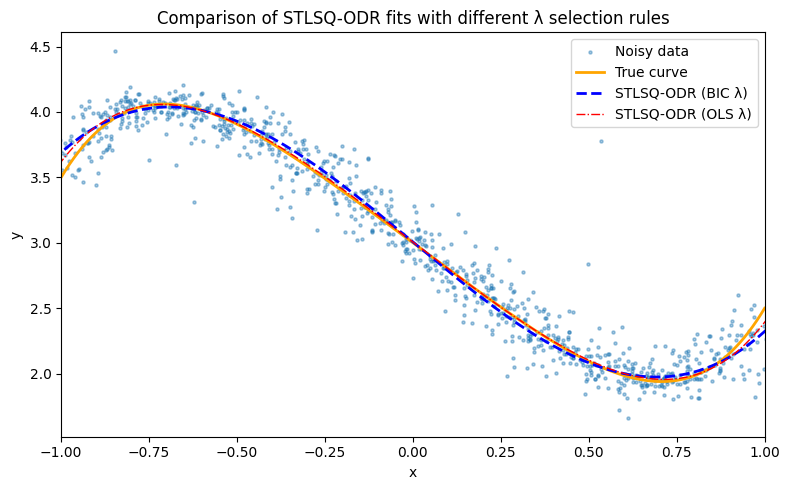

In [40]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add Student-t noise to both x and y
df = 3   # degrees of freedom (small df → heavier tails)
x_noisy = x_true + 0.05 * t.rvs(df, size=m, random_state=0)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.05 * t.rvs(df, size=m, random_state=1)
y = y_noisy[:, None]

# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.10811807510766078
Sparse coeffs: [ 3.0085 -2.3754  0.      2.0041  0.     -0.3805]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.07542211695858951
Sparse coeffs: [ 3.0334 -2.3621 -0.2017  2.1138  0.2086 -0.5214]


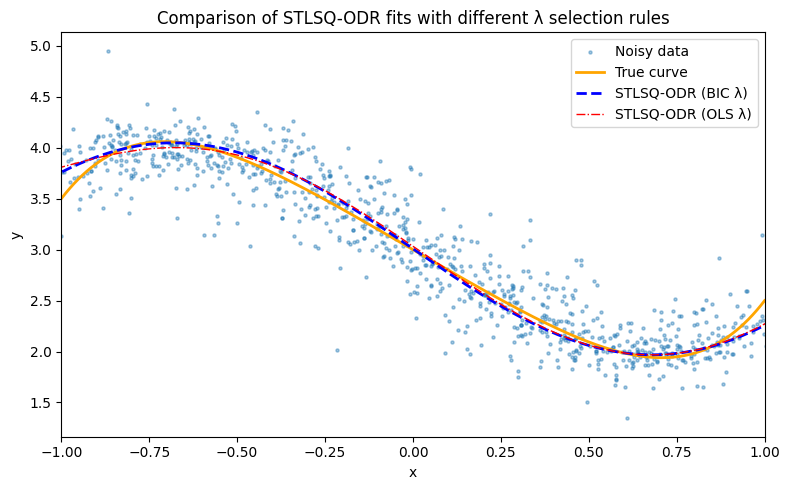

In [39]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add Student-t noise to both x and y
df = 3   # degrees of freedom (small df → heavier tails)
x_noisy = x_true + 0.1 * t.rvs(df, size=m, random_state=0)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * t.rvs(df, size=m, random_state=1)
y = y_noisy[:, None]

# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.44062364277735727
Sparse coeffs: [ 3.0252 -1.1422  0.      0.      0.      0.    ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.020635314829851682
Sparse coeffs: [ 3.0835 -2.0754 -0.3051  1.2203  0.1725 -0.142 ]


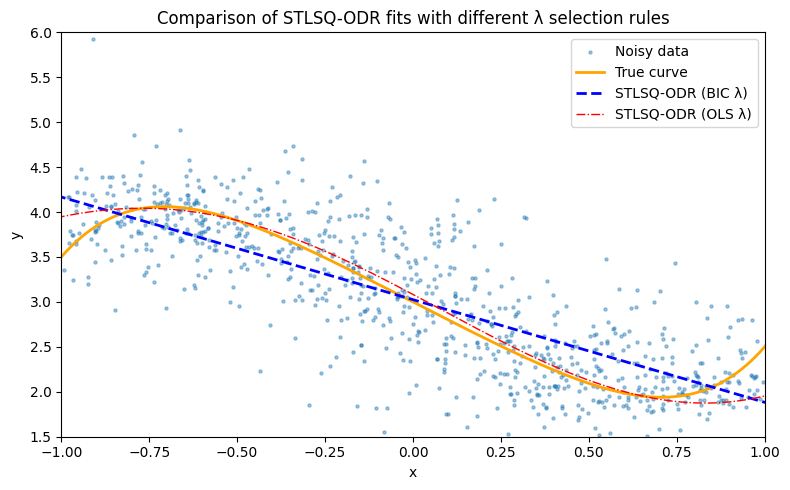

In [50]:
# Prepare data
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add Student-t noise to both x and y
df = 3   # degrees of freedom (small df → heavier tails)
x_noisy = x_true + 0.2 * t.rvs(df, size=m, random_state=0)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.2 * t.rvs(df, size=m, random_state=1)
y = y_noisy[:, None]

# Build design matrix
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data")
plt.plot(x_true, y_clean, color="orange", lw=2, label="True curve")

plt.plot(np.sort(x_noisy),
         y_fit_bic[np.argsort(x_noisy)],
         "--", color="blue", lw=2,
         label="STLSQ-ODR (BIC λ)")

plt.plot(np.sort(x_noisy),
         y_fit_ols[np.argsort(x_noisy)],
         "-.", color="red", lw=1,
         label="STLSQ-ODR (OLS λ)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparison of STLSQ-ODR fits with different λ selection rules")
plt.xlim(-1, 1)   # only show range [-1, 1]
plt.ylim(1.5, 6) 
plt.tight_layout()
plt.show()

# Case 3

=== Method 1 (BIC) ===
Chosen λ     : 0.005790443980602489
Sparse coeffs: [ 3.0006 -2.0066  0.      0.5262  0.      0.9732]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.004136036659664622
Sparse coeffs: [ 2.9991 -2.0066  0.0101  0.526  -0.0118  0.9734]


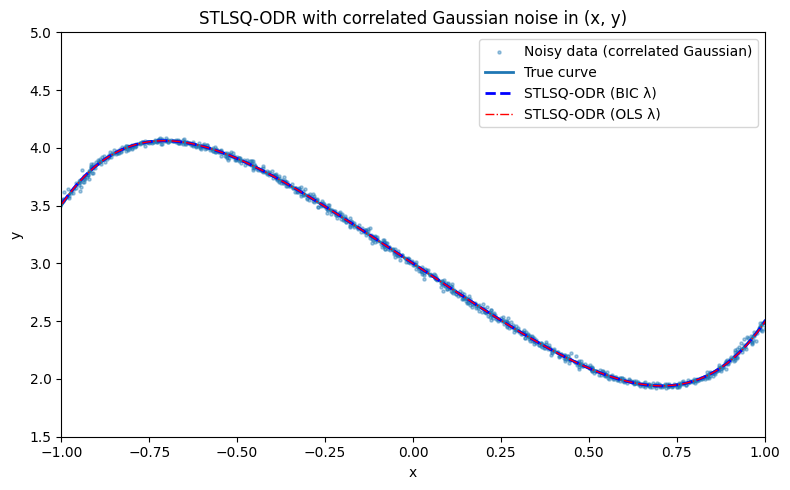

In [13]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.01
sigma_y = 0.01
rho = 0.1  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, color = "blue", label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, color = "red", label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.009249147277217335
Sparse coeffs: [ 3.0008 -2.0076  0.      0.5225  0.      0.9836]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.006491301697259933
Sparse coeffs: [ 2.9983 -2.0075  0.0158  0.522  -0.0179  0.984 ]


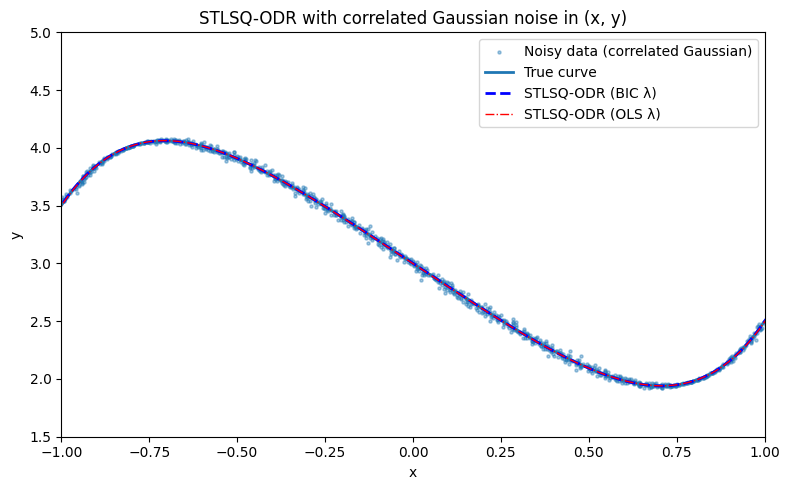

In [14]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.01
sigma_y = 0.01
rho = 1  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, color = "blue", label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, color = "red", label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.02359833466782195
Sparse coeffs: [ 3.0029 -2.0269  0.      0.565   0.      0.9328]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.022611613354489246
Sparse coeffs: [ 2.9962 -2.0254  0.0436  0.5594 -0.049   0.9376]


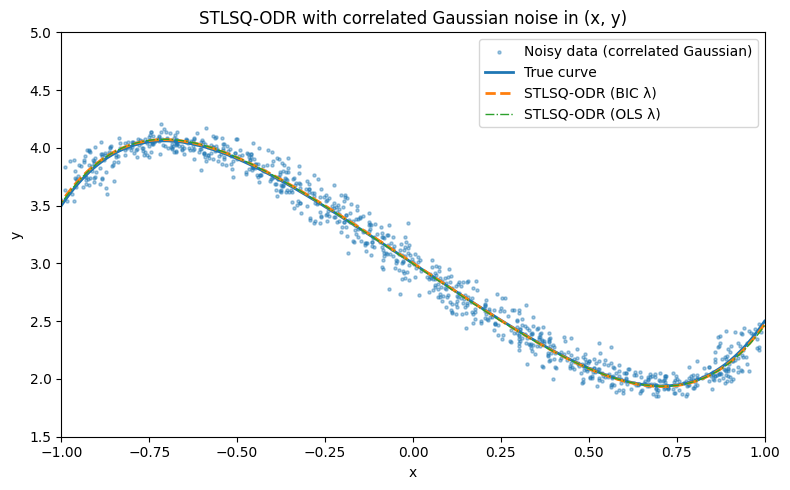

In [ ]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.05
sigma_y = 0.05
rho = 0.1  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, color = "blue", label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, color = "red", label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.02982471286216891
Sparse coeffs: [ 3.003  -2.0703  0.      0.6825  0.      0.8814]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.023186895759535964
Sparse coeffs: [ 2.9931 -2.0689  0.0574  0.6775 -0.0588  0.8855]


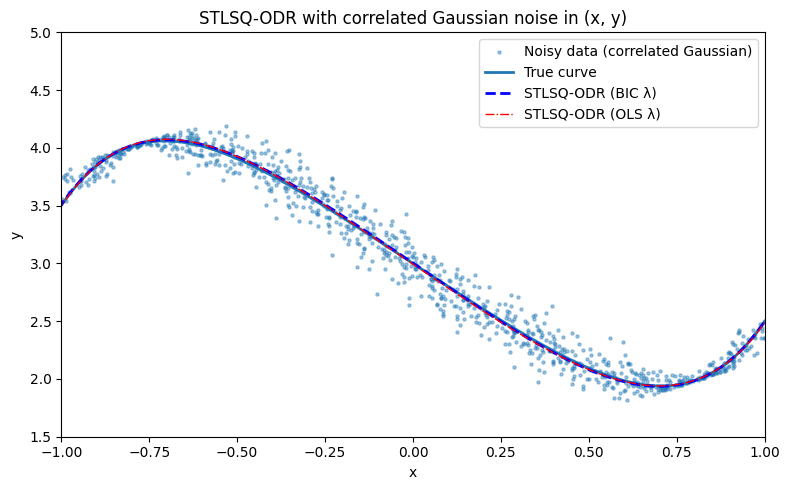

In [8]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.05
sigma_y = 0.05
rho = 1  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, color = "blue", label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, color = "red", label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.02359833466782195
Sparse coeffs: [ 3.003  -2.0511  0.      0.645   0.      0.8794]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.025950721820770097
Sparse coeffs: [ 3.003  -2.0511  0.      0.645   0.      0.8794]


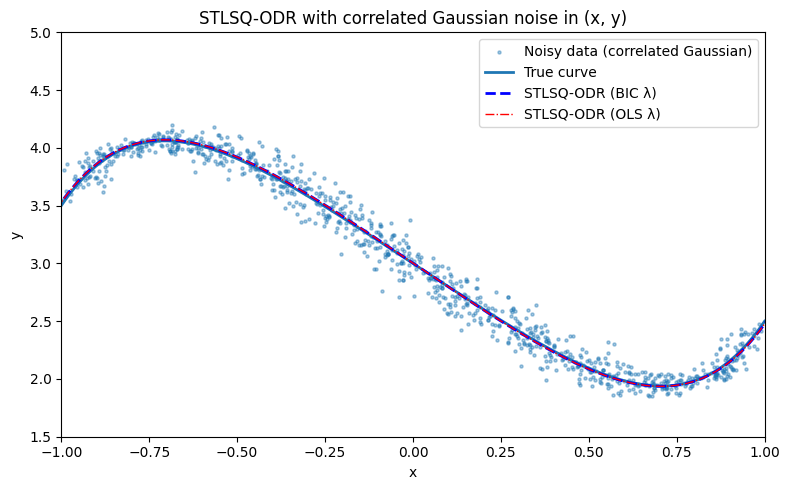

In [9]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.05
sigma_y = 0.05
rho = 0.5  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, color = "blue", label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, color = "red", label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.3919406774847221
Sparse coeffs: [ 3.0047 -2.3393  0.      1.7111  0.      0.    ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.036186715542754704
Sparse coeffs: [ 2.9911 -2.1202  0.081   0.7724 -0.0888  0.857 ]


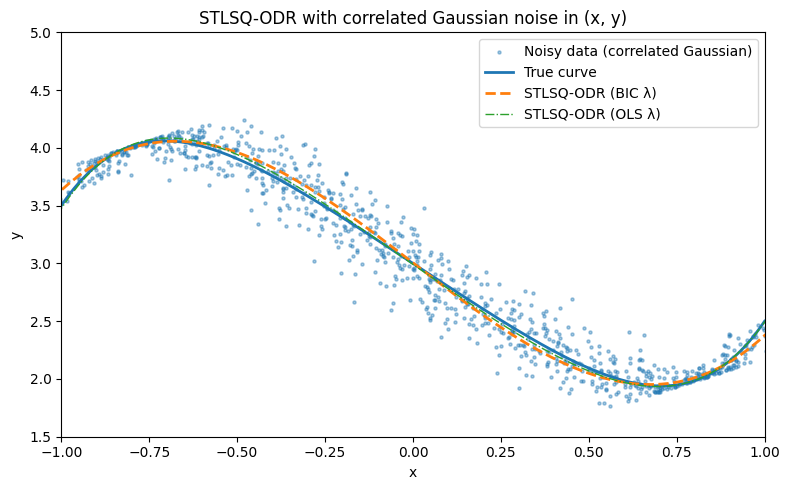

In [12]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.07
sigma_y = 0.07
rho = 1  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.02359833466782195
Sparse coeffs: [ 3.0031 -2.0252  0.      0.5376  0.      0.9553]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.029915319888972846
Sparse coeffs: [ 3.0031 -2.0252  0.      0.5376  0.      0.9553]


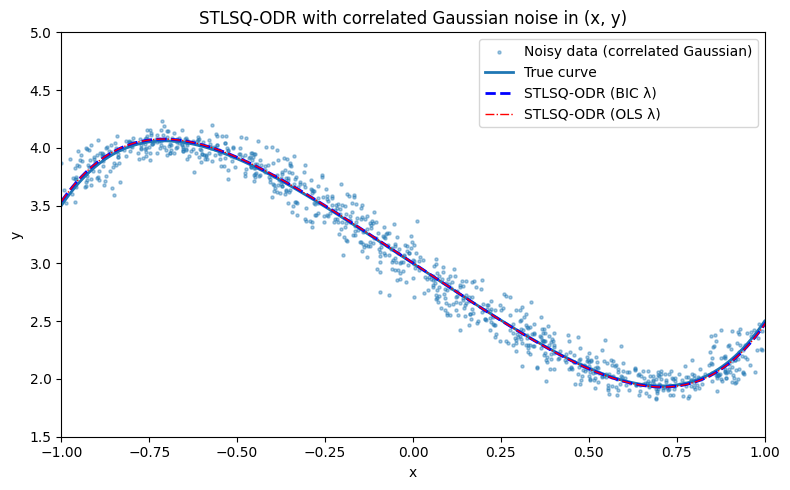

In [10]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Gaussian noise for (x, y) ----------
sigma_x = 0.06
sigma_y = 0.06
rho = 0.1  # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,              rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y, sigma_y**2]
])

# draw m samples of [eps_x, eps_y] from multivariate normal
eps = np.random.multivariate_normal(
    mean=np.zeros(2),
    cov=Sigma,
    size=m
)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated Gaussian noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # STLSQ_ODR should accept (x_noisy, y, deg, lambd, n_iter, sx, sy) in your implementation
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10, sx=sigma_x, sy=sigma_y)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols.ravel())[np.abs(Xi_ols.ravel()) > 1e-12]
lambd = 0.9 * nz.min() if nz.size > 0 else 0.0  # safeguard

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated Gaussian)")
plt.plot(x_true, y_clean, lw=2, label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", lw=2, color = "blue", label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", lw=1, color = "red", label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated Gaussian noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

# Case 4

=== Method 1 (BIC) ===
Chosen λ     : 0.001795714494371641
Sparse coeffs: [ 3.0028 -2.0424  0.      0.6841  0.      0.8141]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.05421852039606632
Sparse coeffs: [ 3.0029 -2.0343  0.      0.6211  0.      0.8845]


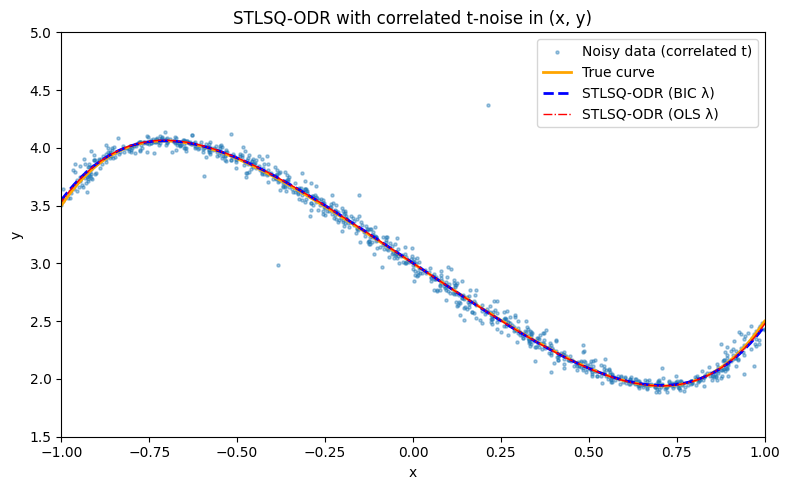

In [7]:

def multivariate_t_rvs(mean, Sigma, df, n):
    """
    mean: (d,)
    Sigma: (d,d) positive-definite scale matrix
    df: degrees of freedom > 0
    n: number of samples
    returns: (n,d)
    """
    mean = np.asarray(mean)
    d = mean.size
    # z ~ N(0, Sigma)
    z = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
    # w ~ ChiSq(df) independent
    w = chi2.rvs(df, size=n)
    # scale each row by sqrt(df / w)
    s = np.sqrt(df / w)[:, None]
    return mean + z * s

# -----------------------------------------
# Prepare data
# -----------------------------------------
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Student-t noise for (x, y) ----------
df = 3                  # degrees of freedom (heavier tails if smaller)
sigma_x = 0.02
sigma_y = 0.02
rho = 0.1               # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,        rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y,  sigma_y**2     ]
])

# draw m samples of [eps_x, eps_y]
eps = multivariate_t_rvs(mean=np.zeros(2), Sigma=Sigma, df=df, n=m)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated t-noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated t)")
plt.plot(x_true, y_clean, lw=2, color="orange", label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", color="blue", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", color="red", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated t-noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()


=== Method 1 (BIC) ===
Chosen λ     : 0.013141473626117567
Sparse coeffs: [ 3.004  -2.0623  0.      0.7353  0.      0.798 ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.026176163761198825
Sparse coeffs: [ 2.9989 -2.0364  0.0464  0.5892 -0.0605  0.9447]


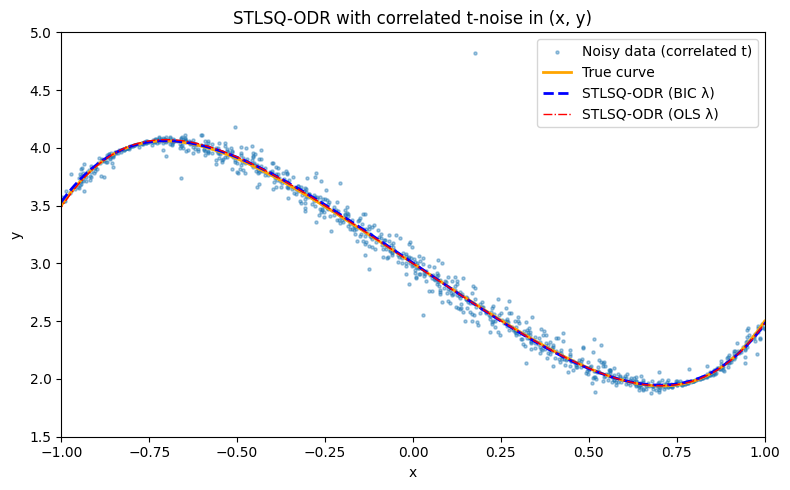

In [64]:

def multivariate_t_rvs(mean, Sigma, df, n):
    """
    mean: (d,)
    Sigma: (d,d) positive-definite scale matrix
    df: degrees of freedom > 0
    n: number of samples
    returns: (n,d)
    """
    mean = np.asarray(mean)
    d = mean.size
    # z ~ N(0, Sigma)
    z = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
    # w ~ ChiSq(df) independent
    w = chi2.rvs(df, size=n)
    # scale each row by sqrt(df / w)
    s = np.sqrt(df / w)[:, None]
    return mean + z * s

# -----------------------------------------
# Prepare data
# -----------------------------------------
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Student-t noise for (x, y) ----------
df = 3                  # degrees of freedom (heavier tails if smaller)
sigma_x = 0.02
sigma_y = 0.02
rho = 1               # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,        rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y,  sigma_y**2     ]
])

# draw m samples of [eps_x, eps_y]
eps = multivariate_t_rvs(mean=np.zeros(2), Sigma=Sigma, df=df, n=m)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated t-noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated t)")
plt.plot(x_true, y_clean, lw=2, color="orange", label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", color="blue", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", color="red", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated t-noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()


=== Method 1 (BIC) ===
Chosen λ     : 0.0032245905452963947
Sparse coeffs: [ 3.0037 -2.0648  0.      0.7548  0.      0.7706]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.031305927478315
Sparse coeffs: [ 3.0039 -2.0471  0.      0.6466  0.      0.8821]


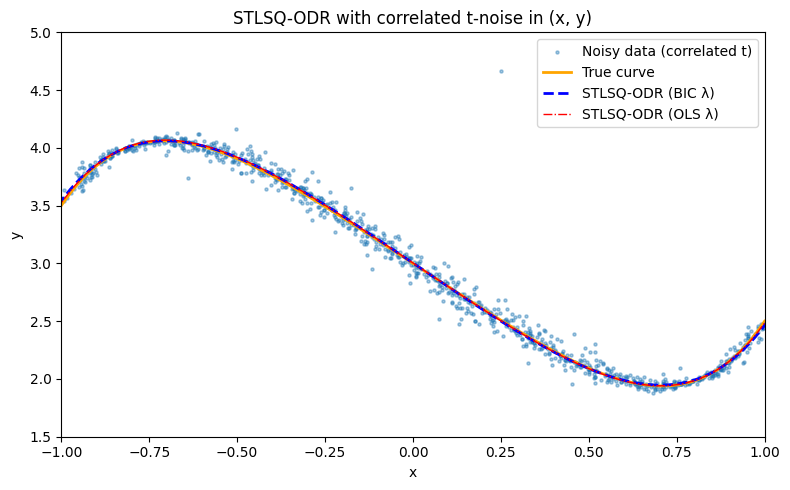

In [74]:

# Prepare data
# -----------------------------------------
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Student-t noise for (x, y) ----------
df = 3                  # degrees of freedom (heavier tails if smaller)
sigma_x = 0.02
sigma_y = 0.02
rho = 0.8               # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,        rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y,  sigma_y**2     ]
])

# draw m samples of [eps_x, eps_y]
eps = multivariate_t_rvs(mean=np.zeros(2), Sigma=Sigma, df=df, n=m)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated t-noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated t)")
plt.plot(x_true, y_clean, lw=2, color="orange", label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", color="blue", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", color="red", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated t-noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.0012638482029342984
Sparse coeffs: [ 3.0033 -2.0577  0.      0.7348  0.      0.7797]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.03712820155450671
Sparse coeffs: [ 3.0035 -2.0443  0.      0.6474  0.      0.8717]


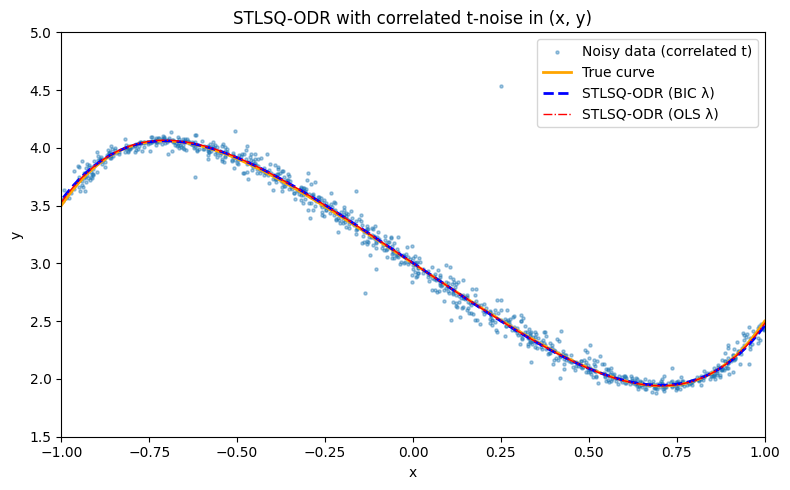

In [75]:
# Prepare data
# -----------------------------------------
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Student-t noise for (x, y) ----------
df = 3                  # degrees of freedom (heavier tails if smaller)
sigma_x = 0.02
sigma_y = 0.02
rho = 0.5               # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,        rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y,  sigma_y**2     ]
])

# draw m samples of [eps_x, eps_y]
eps = multivariate_t_rvs(mean=np.zeros(2), Sigma=Sigma, df=df, n=m)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated t-noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated t)")
plt.plot(x_true, y_clean, lw=2, color="orange", label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", color="blue", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", color="red", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated t-noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()


In [35]:
# L2([-1,1]) normalization factor: factor[k] = sqrt((2k+1)/2)
def l2_norm_factors(deg: int) -> np.ndarray:
    return np.sqrt((2 * np.arange(deg + 1) + 1) / 2)

def _odr_fit_powers(x: np.ndarray,
                    y: np.ndarray,
                    powers: np.ndarray,
                    factors: np.ndarray,
                    beta0: np.ndarray | None = None,
                    sx: float | np.ndarray = 0.06,
                    sy: float | np.ndarray = 0.1) -> np.ndarray:
    powers = np.asarray(powers)

    def poly_model(beta, x):
        out = np.zeros_like(x, dtype=float)
        for j, p in enumerate(powers):
            out += beta[j] * (x**p) * factors[p]  # normalized basis
        return out

    model = odr.Model(poly_model)
    data  = odr.RealData(x, y, sx=sx, sy=sy, covx=0.1, covy=0.1)

    if beta0 is None:
        # Use the normalized Θ submatrix to perform LSQ as the initial guess
        Theta_norm = np.vstack([(x**p) * factors[p] for p in powers]).T
        beta0 = np.linalg.lstsq(Theta_norm, y, rcond=None)[0].ravel()

    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta  # coefficients under the normalized basis (corresponding to powers)

# STLSQ + ODR (internally uses normalized coefficients, finally denormalizes)
def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:
    """
    Returns: beta (deg+1, n_states) — denormalized, can be directly multiplied with x^k
    """
    factors = l2_norm_factors(deg)
    n_features, n_states = deg + 1, dXdt.shape[1]

    # Xi_norm: coefficients under the normalized basis
    Xi_norm = np.zeros((n_features, n_states))
    all_powers = np.arange(deg + 1)

    # Initial fitting (all powers)
    for k in range(n_states):
        Xi_norm[:, k] = _odr_fit_powers(x, dXdt[:, k], all_powers, factors, sx=sx, sy=sy)

    # Iterative sparsification (thresholding on the normalized scale)
    for _ in range(n_iter):
        small = np.abs(Xi_norm) < lambd
        Xi_norm[small] = 0.0

        for k in range(n_states):
            powers_kept = np.flatnonzero(~small[:, k])
            if powers_kept.size == 0:
                continue
            # Refit on the retained powers
            beta_sub = _odr_fit_powers(x, dXdt[:, k], powers_kept, factors, sx=sx, sy=sy)
            # Write back to the corresponding positions (still under normalized basis)
            Xi_norm[powers_kept, k] = beta_sub
            # Deleted terms remain as 0

    # Denormalize to standard polynomial coefficients: beta = Xi_norm * factor
    beta = Xi_norm * factors[:, None]
    return beta


=== Method 1 (BIC) ===
Chosen λ     : 0.0032245905452963947
Sparse coeffs: [ 3.0037 -2.0648  0.      0.7548  0.      0.7706]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.031305927478315
Sparse coeffs: [ 3.0039 -2.0471  0.      0.6466  0.      0.8821]


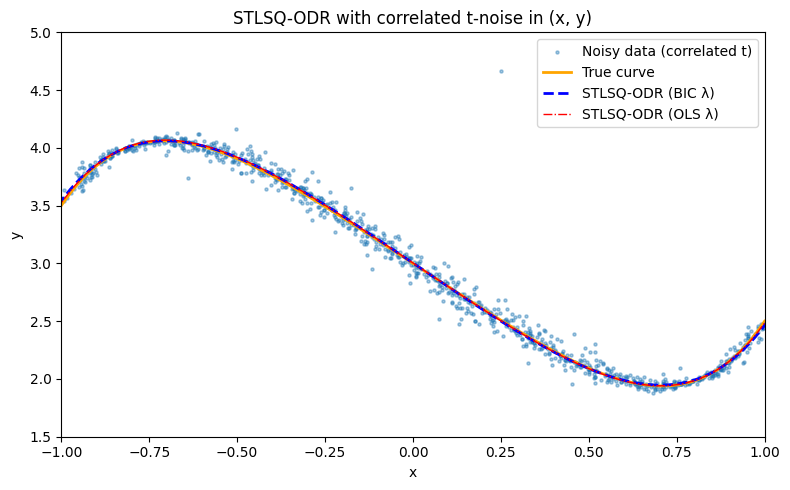

In [ ]:

# Prepare data
# -----------------------------------------
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Student-t noise for (x, y) ----------
df = 3                  # degrees of freedom (heavier tails if smaller)
sigma_x = 0.03
sigma_y = 0.02
rho = 0.8               # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,        rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y,  sigma_y**2     ]
])

# draw m samples of [eps_x, eps_y]
eps = multivariate_t_rvs(mean=np.zeros(2), Sigma=Sigma, df=df, n=m)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated t-noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated t)")
plt.plot(x_true, y_clean, lw=2, color="orange", label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", color="blue", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", color="red", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated t-noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

=== Method 1 (BIC) ===
Chosen λ     : 0.34863652276780877
Sparse coeffs: [ 3.0011 -2.2716  0.      1.6172  0.      0.    ]
=== Method 2 (OLS×0.9) ===
Chosen λ     : 0.15697964995436015
Sparse coeffs: [ 2.9992 -2.0275  0.      0.4503  0.      1.0872]


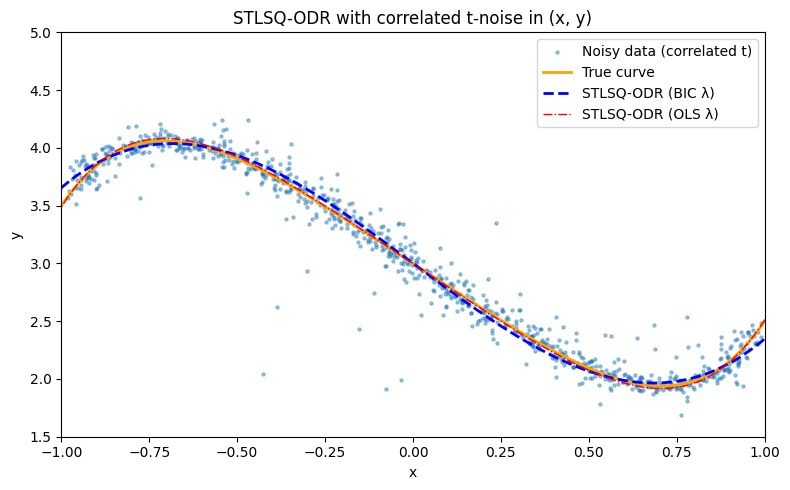

In [9]:

# Prepare data
# -----------------------------------------
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# ---------- correlated Student-t noise for (x, y) ----------
df = 2                  # degrees of freedom (heavier tails if smaller)
sigma_x = 0.03
sigma_y = 0.03
rho = 0.1               # correlation between x-noise and y-noise

Sigma = np.array([
    [sigma_x**2,        rho * sigma_x * sigma_y],
    [rho * sigma_x * sigma_y,  sigma_y**2     ]
])

# draw m samples of [eps_x, eps_y]
eps = multivariate_t_rvs(mean=np.zeros(2), Sigma=Sigma, df=df, n=m)
eps_x = eps[:, 0]
eps_y = eps[:, 1]

# add correlated t-noise to both x and y
x_noisy = x_true + eps_x
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + eps_y
y = y_noisy[:, None]

# -----------------------------------------
# Build design matrix
# -----------------------------------------
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -----------------------------------------
# Method 1: λ grid search with BIC
# -----------------------------------------
lambdas = np.logspace(-3, 0, 60)  # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)
    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("=== Method 1 (BIC) ===")
print("Chosen λ     :", best_lam)
print("Sparse coeffs:", np.round(best_Xi, 4))

y_fit_bic = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Method 2: λ = 0.9 * min(nonzero |OLS coef|)
# -----------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)
nz = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]
lambd = 0.9 * nz.min()

Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=sigma_x, sy=sigma_y   # keep per-dim scales consistent with noise
).ravel()

print("=== Method 2 (OLS×0.9) ===")
print("Chosen λ     :", lambd)
print("Sparse coeffs:", np.round(Xi_sparse, 4))

y_fit_ols = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.4, label="Noisy data (correlated t)")
plt.plot(x_true, y_clean, lw=2, color="orange", label="True curve")

order = np.argsort(x_noisy)
plt.plot(x_noisy[order], y_fit_bic[order], "--", color="blue", lw=2, label="STLSQ-ODR (BIC λ)")
plt.plot(x_noisy[order], y_fit_ols[order], "-.", color="red", lw=1, label="STLSQ-ODR (OLS λ)")

plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.title("STLSQ-ODR with correlated t-noise in (x, y)")
plt.xlim(-1, 1)
plt.ylim(1.5, 5)
plt.tight_layout()
plt.show()

# none finished

In [4]:
import numpy as np
import itertools
from scipy import odr


def _get_poly_terms(x: np.ndarray, deg: int):
    """
    Generate polynomial features up to total degree `deg` for each sample in x
    x: (n_samples, n_inputs)
    return: (n_samples, n_terms), list of exponents
    """
    n_samples, n_inputs = x.shape
    # all combinations of exponents with total degree <= deg
    powers = [p for d in range(deg + 1)
                for p in itertools.product(range(d + 1), repeat=n_inputs)
                if sum(p) == d]

    X_poly = np.zeros((n_samples, len(powers)))
    for i, power in enumerate(powers):
        X_poly[:, i] = np.prod(x ** power, axis=1)
    return X_poly, powers


def _poly_model_factory(powers):
    def model(beta, x_flat):
        x = x_flat.reshape(-1, len(powers[0]))
        y = np.zeros(x.shape[0])
        for i, power in enumerate(powers):
            y += beta[i] * np.prod(x ** power, axis=1)
        return y
    return model


def _odr_fit(x: np.ndarray,
             b: np.ndarray,
             true_coeffs,
             deg: int,
             beta0: np.ndarray | None = None,
             sx: float | np.ndarray = 0.06,
             sy: float | np.ndarray = 0.1) -> np.ndarray:

    X_poly, powers = _get_poly_terms(x, deg)
    model = odr.Model(_poly_model_factory(powers))
    data = odr.RealData(x=x.reshape(-1, x.shape[1]).T, y=b, sx=sx, sy=sy)

    if beta0 is None:
        beta0 = np.linalg.lstsq(X_poly, b, rcond=None)[0]

    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta, powers


def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:

    X_poly, powers = _get_poly_terms(x, deg)
    n_features, n_states = X_poly.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    dummy_coeffs = np.empty(n_features)
    for k in range(n_states):
        Xi[:, k], _ = _odr_fit(x,
                               dXdt[:, k],
                               true_coeffs=dummy_coeffs,
                               deg=deg,
                               sx=sx, sy=sy)

    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue

            kept_powers = [powers[i] for i in range(len(powers)) if keep[i]]
            def sub_model(beta, x_flat):
                x = x_flat.reshape(-1, x.shape[1])
                y = np.zeros(x.shape[0])
                for i, power in enumerate(kept_powers):
                    y += beta[i] * np.prod(x ** power, axis=1)
                return y

            data = odr.RealData(x=x.T, y=dXdt[:, k], sx=sx, sy=sy)
            beta0 = Xi[keep, k]
            model = odr.Model(sub_model)
            out = odr.ODR(data, model, beta0=beta0).run()
            Xi[keep, k] = out.beta

    return Xi



In [8]:
def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:

    X_poly, powers = _get_poly_terms(x, deg)
    n_samples, n_inputs = x.shape
    n_features, n_states = X_poly.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    dummy_coeffs = np.empty(n_features)
    for k in range(n_states):
        Xi[:, k], _ = _odr_fit(x,
                               dXdt[:, k],
                               true_coeffs=dummy_coeffs,
                               deg=deg,
                               sx=sx, sy=sy)

    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue

            kept_powers = [powers[i] for i in range(len(powers)) if keep[i]]
            def sub_model(beta, x_flat):
                x = x_flat.reshape(-1, n_inputs)  # ✅ FIX HERE
                y = np.zeros(x.shape[0])
                for i, power in enumerate(kept_powers):
                    y += beta[i] * np.prod(x ** power, axis=1)
                return y

            data = odr.RealData(x=x.T, y=dXdt[:, k], sx=sx, sy=sy)
            beta0 = Xi[keep, k]
            model = odr.Model(sub_model)
            out = odr.ODR(data, model, beta0=beta0).run()
            Xi[keep, k] = out.beta

    return Xi


In [5]:
from scipy.integrate import odeint
from itertools import combinations_with_replacement

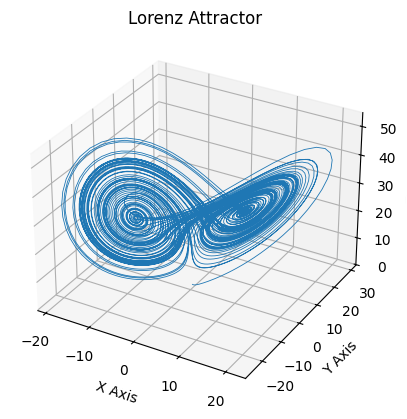

In [5]:
# initial code from wikipedia
def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.6)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [12]:
### Dataset

def lorenz63(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return (dxdt, dydt, dzdt)

# Integrate
sigma, rho, beta = 10.0, 28.0, 8 / 3
x0 = (-8, 8, 27)
dt = 0.01
t  = np.arange(0.0, 10 + dt, dt)
X_true = odeint(lorenz63, x0, t, args=(sigma, rho, beta)) # Trajectory


# add noise
noise_level = 0.01
rng = np.random.default_rng(0)
X_noisy = X_true + noise_level * rng.standard_normal(X_true.shape)

# Estimate using a second-order central difference
dXdt = np.gradient(X_noisy, dt, axis=0, edge_order=2)


➜  Best λ = 1

ẋ = +1.309y -1.015x
ẏ = -5.2791 +4.713y -4.135x
ż = 


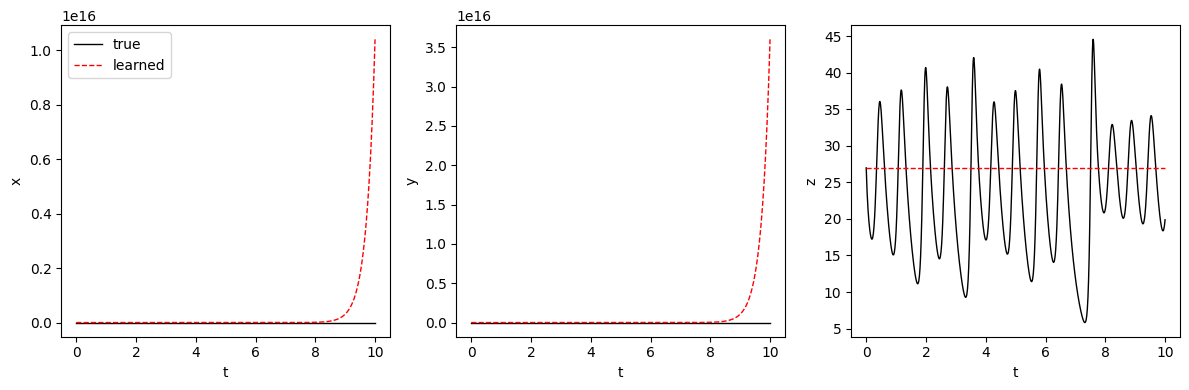

In [14]:
# λ grid search with BIC
degree = 2
lambdas = np.logspace(-3, 0, 60)
best_bic = np.inf
best_Xi = None
best_lam = None
n_samples = len(t)

for lam in lambdas:
    Xi = STLSQ_ODR(X_noisy, dXdt, deg=degree, lambd=lam, n_iter=10)
    Theta, powers = _get_poly_terms(X_noisy, degree)
    rss = np.sum((dXdt - Theta @ Xi) ** 2)
    k = np.count_nonzero(Xi)
    bic = n_samples * np.log(rss / n_samples + 1e-12) + k * np.log(n_samples)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi, lam


# model
var_names = ['x', 'y', 'z']
term_names = ['*'.join(f'{var_names[j]}' * e for j, e in enumerate(p) if e > 0) or '1' for p in powers]

print(f"\n➜  Best λ = {best_lam:.3g}\n")
for state_name, coeffs in zip(["ẋ", "ẏ", "ż"], best_Xi.T):
    terms = [f"{c:+.3f}{n}" for c, n in zip(coeffs, term_names) if abs(c) > 1e-3]
    print(f"{state_name} = {' '.join(terms)}")


# Verification track
def rhs_learned(state, t, Xi=best_Xi, deg=degree):
    theta_row, _ = _get_poly_terms(np.array(state).reshape(1, -1), deg)
    return (theta_row @ Xi).flatten().tolist()

X_learned = odeint(rhs_learned, X_noisy[0], t)


fig = plt.figure(figsize=(12, 4))
for i, lbl in enumerate('xyz'):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(t, X_true[:, i], 'k', lw=1, label='true')
    ax.plot(t, X_learned[:, i], '--r', lw=1, label='learned')
    if i == 0:
        ax.legend()
    ax.set_xlabel('t')
    ax.set_ylabel(lbl)
plt.tight_layout()
plt.show()